In [9]:
#Initializations
import math
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold

# Load dataset
df = pd.read_csv("../../train.csv")
X = df["Text"].values
y = df["Category"].values
m = 0.9 #proportion of data for training vs validation
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=m, random_state=42, shuffle=True)

### Task 2a

(a) NB. Train a Naive Bayes classifier using all articles features. Report the (i) top-20 most identifiable words that are most likely to occur in the articles over two classes using your NB classifier, and (ii) the top-20 words that maximize the following quantity:
𝑷𝑷(𝑿𝑿𝒘𝒘 = 𝟏𝟏|𝒀𝒀 = 𝒚𝒚)/𝑷𝑷(𝑿𝑿𝒘𝒘 = 𝟏𝟏|𝒀𝒀 ≠ 𝒚𝒚).

Which list of words describe the two classes better? Briefly explain your reasoning.

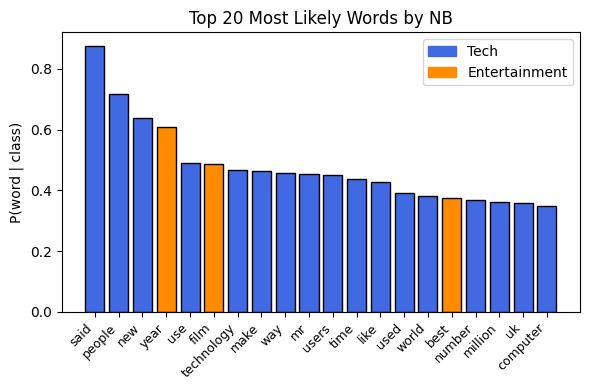

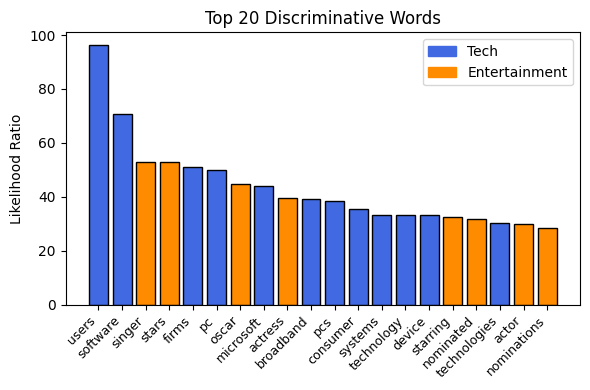

In [10]:
# Vectorize data
vectorizer = CountVectorizer(binary=True, stop_words='english')
X_bin = vectorizer.fit_transform(X)
vocab = np.array(vectorizer.get_feature_names_out())

def get_word_stats(class_label):
    #Compute P(w|class), P(w|not class), and likelihood ratio
    X_class = X_bin[y == class_label]
    X_not_class = X_bin[y != class_label]

    Pw_class = (X_class.sum(axis=0) + 1) / (X_class.shape[0] + 2)
    Pw_not_class = (X_not_class.sum(axis=0) + 1) / (X_not_class.shape[0] + 2)
    ratio = (Pw_class / Pw_not_class).A1
    probs = Pw_class.A1

    return probs, ratio

# Compute stats for both classes
probs_tech, ratios_tech = get_word_stats("tech")
probs_ent, ratios_ent = get_word_stats("entertainment")

def combine_and_rank(metric_tech, metric_ent):
    #Combine both class metrics and select top K words
    top_tech = np.argsort(metric_tech)[-20:]
    top_ent = np.argsort(metric_ent)[-20:]
    combined = np.unique(np.concatenate((top_tech, top_ent)))

    vals, classes = [], []
    for i in combined:
        if metric_tech[i] > metric_ent[i]:
            vals.append(metric_tech[i])
            classes.append("tech")
        else:
            vals.append(metric_ent[i])
            classes.append("entertainment")

    sorted_idx = np.argsort(vals)[-20:][::-1]
    return vocab[combined][sorted_idx], np.array(vals)[sorted_idx], np.array(classes)[sorted_idx]

def plot_bar(words, values, classes, ylabel, title):
    """Plot the bar chart."""
    colors = ['royalblue' if c == "tech" else 'darkorange' for c in classes]
    plt.figure(figsize=(6, 4))
    plt.bar(words, values, color=colors, edgecolor='black')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(handles=[
        plt.Rectangle((0, 0), 1, 1, color='royalblue', label='Tech'),
        plt.Rectangle((0, 0), 1, 1, color='darkorange', label='Entertainment')
    ])
    plt.tight_layout()
    plt.show()

# ==== PLOT 1: Top 20 by Raw Class Likelihood ====
words_likelihood, vals_likelihood, class_likelihood = combine_and_rank(probs_tech, probs_ent)
plot_bar(words_likelihood, vals_likelihood, class_likelihood, "P(word | class)", "Top 20 Most Likely Words by NB")

# ==== PLOT 2: Top 20 by Likelihood Ratio ====
words_ratio, vals_ratio, class_ratio = combine_and_rank(ratios_tech, ratios_ent)
plot_bar(words_ratio, vals_ratio, class_ratio, "Likelihood Ratio", "Top 20 Discriminative Words")




Reasoning Explanation: By taking a brief look at our results of (i) and (ii), its clear that our 2nd bar graph of words describes the two classes better... For the 1st graph, we measured and ranked the words based on their probability of occuring given a category. The most likely word was 'said' for the tech category, which intuitively doesn't tell us much regarding classificaiton (And this is also despite cleaning stop words such as 'and'). However, the 2nd graph has words such as 'users' and 'software' to classify a tech news article, and words such as 'singer' and 'stars' to classify an entertainment article, which, makes sense! 

Though we got rid of stop words, for the sake of example, words such as 'the' or 'and' might be the most likely words in both Tech and Entertainment, but these words don't help us distinguish between the two classes. By using discriminative words, we reduce noise and increase signal, thus improving classification accuracy. We can also see that on our 2nd graph, we have a better variety of words that help us indentify each category, rather than mainly Tech (This could be due to Tech write-ups having more words or less variety in terms of text descriptions). 

### Task 3

(a) We explore how the size of the training data set affects the test and train accuracy. For each
value of m in [0.1, 0.3, 0.5, 0.7, 0.9], train your classifier on the first m portion of the training
examples (that is, use the data given by XTrain[0:mN] and yTrain[0:mN]). Please report two
plots: (i) training and (ii) testing accuracy for each such value of m with the x-axis referring to m
and the y-axis referring to the classification accuracy in 𝐹1 measure as shown below. In total,
there should be four curves for training accuracy and four curves for testing accuracy. Explain
the general trend of the two plots in terms of training and testing accuracy if any.

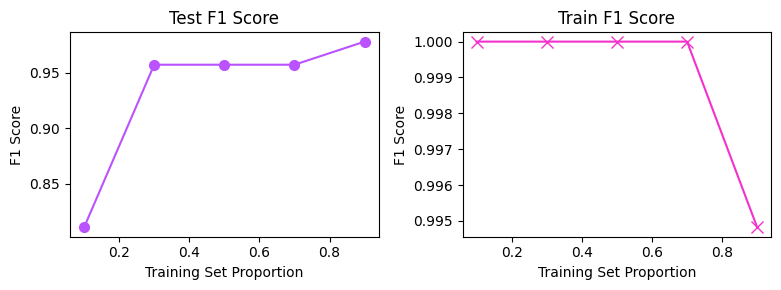

In [11]:
#train classifier on different training sizes

def train_on_m(train_y, vector, vector_test, m, y_test):
    sub_vector = vector[0:round(vector.shape[0]*m)]
    probs, clf = make_classifier(sub_vector, train_y[0:round(len(train_y)*m)], vector_test)
    preds_test = clf.predict(vector_test)
    preds_train = clf.predict(sub_vector)
    train_f1 = calc_f1(preds_train, train_y[0:round(len(train_y)*m)])
    test_f1 = calc_f1(preds_test, y_test)

    return train_f1, test_f1

def calc_f1(preds, actual):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
# tech is positive
    for i in range(len(preds)):
        if preds[i] == "tech" and actual[i] == "tech":
            tp += 1
        elif preds[i] == "tech" and actual[i] == "entertainment":
            fp += 1
        elif preds[i] == "entertainment" and actual[i] == "entertainment":
            tn += 1
        else:
            fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*((precision*recall) / (precision+recall))

    return f1

def vectorize(data, test_data):
    vectorizer = CountVectorizer(stop_words='english', binary=True)
    vectorizer.fit(data["Text"])
    vector = vectorizer.transform(data["Text"])
    test_vector = vectorizer.transform(test_data["Text"])
    return vector, test_vector

# passes in training xs, training ys, testing xs
''' THIS IS THE CLASSIFIER FUNCTION YOU SHOULD MIRROR FOR YOUR MODEL FOR IT TO WORK WITH TASK 3
    IGNORE num_nodes that is specific to the NN classifier. 
'''
def make_classifier(vector, y, vector_test, num_nodes = 5, alpha = 1): 
    clf = MultinomialNB(alpha=alpha)
    clf.fit(vector, y)
    probs = clf.predict_proba(vector_test)
    return probs, clf

def main():
    data = pd.read_csv("../../train.csv")
    y = data["Category"]
    test_data = pd.read_csv("../../test.csv")
    y_test = test_data["Category"]       
    vector, vector_test = vectorize(data, test_data)

    ms = [0.1, 0.3, 0.5, 0.7, 0.9]
    test_f1s = []
    train_f1s = []

    for m in ms:
        train_f1, test_f1 = train_on_m(y, vector, vector_test, m, y_test)
        test_f1s.append(test_f1)
        train_f1s.append(train_f1)


    fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns

    # Plot test F1
    axes[0].plot(ms, test_f1s, marker="o", color="#BA52FF", markersize=7)
    axes[0].set_title("Test F1 Score")
    axes[0].set_xlabel("Training Set Proportion")
    axes[0].set_ylabel("F1 Score")

    # Plot train F1
    axes[1].plot(ms, train_f1s, marker="x", color="#F431CB", markersize=8)
    axes[1].set_title("Train F1 Score")
    axes[1].set_xlabel("Training Set Proportion")
    axes[1].set_ylabel("F1 Score")

    plt.tight_layout()  # Prevent overlap
    plt.show()
        
main()


(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key
hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the
classification accuracy may be significantly affected by the kernels and hyperparameter
combination. List hyperparameters for each classifier and demonstrate how these
hyperparameters impact on the testing accuracy.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

#use 5-fold CV to assess performance, experiment w diff hyperparams

# Load your data
df = pd.read_csv("../../train.csv")
X = df["Text"]
y = df["Category"]
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=42, shuffle=True)

# Define hyperparameter values to try
alphas = [0.01, 0.1, 1.0, 2.0]
ngram_ranges = [(1, 1), (1, 2)]   # unigram and bigram test
binary_options = [False, True]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for alpha in alphas:
    for ngram in ngram_ranges:
        for binary in binary_options:
            f1_scores = []

            for train_index, val_index in kf.split(X):
                X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
                y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

                # Vectorize
                vectorizer = CountVectorizer(binary=binary, stop_words="english", ngram_range=ngram)
                # vectorizer = TfidfVectorizer(binary=binary, stop_words="english", ngram_range=ngram)

                X_train_vec = vectorizer.fit_transform(X_train_fold)
                X_val_vec = vectorizer.transform(X_val_fold)

                # Train
                clf = MultinomialNB(alpha=alpha)  # Removed fit_prior
                clf.fit(X_train_vec, y_train_fold)

                # Predict and evaluate
                y_pred = clf.predict(X_val_vec)
                f1 = calc_f1(list(y_pred), list(y_val_fold))
                f1_scores.append(f1)

            avg_f1 = np.mean(f1_scores)
            results.append({
                "alpha": alpha,
                "ngram_range": ngram,
                "binary": binary,
                "f1_score": avg_f1
            })

# Sort and display
results = sorted(results, key=lambda x: x['f1_score'], reverse=True)
for result in results:
    print(f"Alpha: {result['alpha']}, N-Gram: {result['ngram_range']}, Binary: {result['binary']}, F1 Score: {result['f1_score']:.4f}")


Alpha: 0.1, N-Gram: (1, 1), Binary: False, F1 Score: 0.9838
Alpha: 1.0, N-Gram: (1, 1), Binary: False, F1 Score: 0.9837
Alpha: 0.1, N-Gram: (1, 2), Binary: False, F1 Score: 0.9817
Alpha: 1.0, N-Gram: (1, 2), Binary: False, F1 Score: 0.9817
Alpha: 2.0, N-Gram: (1, 1), Binary: False, F1 Score: 0.9817
Alpha: 0.1, N-Gram: (1, 1), Binary: True, F1 Score: 0.9815
Alpha: 0.1, N-Gram: (1, 2), Binary: True, F1 Score: 0.9815
Alpha: 0.01, N-Gram: (1, 1), Binary: False, F1 Score: 0.9791
Alpha: 1.0, N-Gram: (1, 1), Binary: True, F1 Score: 0.9769
Alpha: 0.01, N-Gram: (1, 2), Binary: False, F1 Score: 0.9748
Alpha: 0.01, N-Gram: (1, 2), Binary: True, F1 Score: 0.9745
Alpha: 1.0, N-Gram: (1, 2), Binary: True, F1 Score: 0.9726
Alpha: 0.01, N-Gram: (1, 1), Binary: True, F1 Score: 0.9724
Alpha: 2.0, N-Gram: (1, 2), Binary: False, F1 Score: 0.9682
Alpha: 2.0, N-Gram: (1, 1), Binary: True, F1 Score: 0.9662
Alpha: 2.0, N-Gram: (1, 2), Binary: True, F1 Score: 0.9553


For the Naive Bayes classifier, we looked at the following hyperparameters: alpha smoothing parameter, use of unigrams vs bigrams, use of binary vectorization, and processing technique (Bag of words vs Term frequency). 